In [1]:
import numpy as np
import pandas as pd
from toolz import curry
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import cvxpy as cp

import toolz as f

from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore')

from matplotlib import style
style.use("ggplot")

# Conformal Inference for Synthetic Controls
 
## Synthetic Control Refresher
 
Synthetic Control (SC) is a particularly useful causal inference technique for when you have a single treatment unit and very few control units, but you have repeated observation of each unit through time (although there are plenty of SC extensions in the Big Data world). The canonical use case is when you want to know the impact of the treatment in one geography (like a state) and you use the other untreated states as controls. In our Synthetic Control chapter, we've motivated the technique by trying to estimate the effect of Proposition 99 (a bill passed in 1988 that increased cigarette tax in California) in cigarette sales. 
 
In order to do that, we have to estimate what would have happened to California, had it not passed Proposition 99. This boils down to estimating the counterfactual $Y_{t}(0)$ so that we can compare it to the observed outcome in the post intervention periods:
 
$$
ATT = Y_{t}(1) - Y_{t}(0) = Y_{t} - Y_{t}(0)  \text{ for } t \geq 1988
$$
 
There are many methods to do that, among which, we have Synthetic Controls. Synthetic Controls tries to model $Y(0)$ for the treated unit by combining multiple control units in such a way that they mimic the pre-treatment behavior of the treated unit. In our case, this means finding a combination of states that, together,  approximate the cigarette sales trend in California prior to Proposition 99. This is done because we rarely have a control unit that follows the same pattern as the treatment unit. We can see that by plotting the cigarette sales trend for multiple states. Notice none of them have a trend that closely resembles that of California. 

In [2]:
data = pd.read_csv("data/smoking.csv")

data = data.pivot("year", "state", "cigsale")
data = data.rename(columns={c: f"state_{c}" for c in data.columns}).rename(columns={"state_3": "california"})
data.shape

(31, 39)

Text(0, 0.5, 'Cigarette Sales')

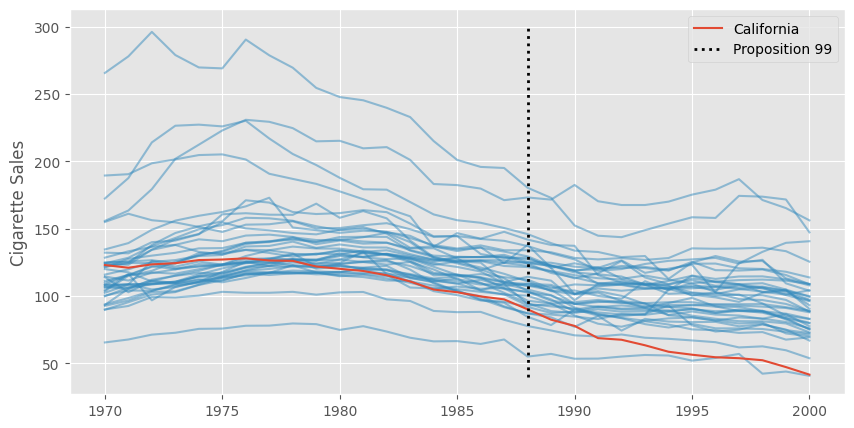

In [3]:
plt.figure(figsize=(10,5))
plt.plot(data.drop(columns=["california"]), color="C1", alpha=0.5)
plt.plot(data["california"], color="C0", label="California")
plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")

That is why we combine multiple treated units. The goal is, if we don't have a good enough control, we can craft a synthetic one that resembles the treated unit the way we want. 
 
In order to find the combination of states that better approximate the pretreatment trend of California, the Synthetic Control method runs a horizontal regression, where the rows are the time periods and the columns are the states. It tries to find the weights that, when multiplied by the control states, better approximate the treated state
 
![img](data/img/synth-control/regr_space.png)
 
Since we have more states (39, some were discarded from the analysis) than time periods, an unconstrained regression would simply overfit, which is why Synthetic Control imposes two restrictions:
 
1. Weights must sum to 1;
2. Weights must be non-negative;
 
Or, in mathematical terms, let $\pmb{y}$ be the vector of outcomes for the treated state in the pre-treated periods, $\pmb{X}$ the $J$ by $T0$ matrix, where each column is a state $j$ and each row is a period $t$ prior to the intervention period, $T1 = T0 + 1$
 
$$
\underset{w}{\mathrm{argmin}} \ ||\pmb{y} - \pmb{X} \pmb{w}|| \\
\text{s.t } \ \sum w_j = 1 \text{ and } \ w_j > 0 \ \forall \ j
$$
 
Combined, these constraints means we are defining the synthetic control as a convex combination of the control units. It also means we are not doing any dangerous extrapolation and that our synthetic control will use only a small subset of control units. 
 
![img](data/img/synth-control/extrapolation.png)
 
Here is what this looks like in code, as an Sklearn estimator:

In [4]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import cvxpy as cp

class SyntheticControl(BaseEstimator, RegressorMixin):

    def __init__(self,):
        pass

    def fit(self, X, y):

        X, y = check_X_y(X, y)
    
        w = cp.Variable(X.shape[1])
        objective = cp.Minimize(cp.sum_squares(X@w - y))
        
        constraints = [cp.sum(w) == 1, w >= 0]
        
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        
        self.X_ = X
        self.y_ = y
        self.w_ = w.value
        
        self.is_fitted_ = True
        return self
        
        
    def predict(self, X):

        check_is_fitted(self)
        X = check_array(X)
        
        return X @ self.w_

Let's apply this method to our data, fitting it in the pre-intervention period (prior to 1988).

In [5]:
model = SyntheticControl()

train = data[data.index < 1988]

model.fit(train.drop(columns=["california"]), train["california"]);

We can now plot, side by side the trend for California and for the synthetic control we've just created. The difference between these two lines is the estimated effect of Proposition 99 in California.

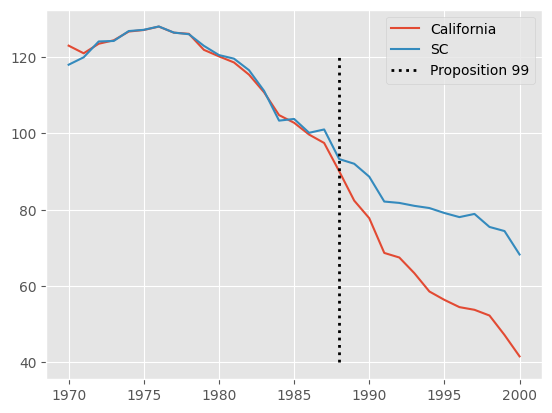

In [6]:
plt.plot(data["california"], label="California")
plt.plot(data["california"].index, model.predict(data.drop(columns=["california"])), label="SC")
plt.vlines(x=1988, ymin=40, ymax=120, linestyle=":", lw=2, label="Proposition 99", color="black")

plt.legend();

From the look of this plot, it looks like Proposition 99 had a pretty big effect on the reduction of cigarette sales.

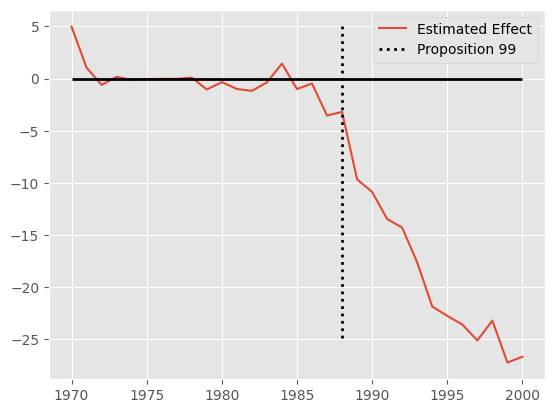

In [7]:
pred_data = data.assign(**{"residuals": data["california"] - model.predict(data.drop(columns=["california"]))})

plt.plot(pred_data["california"].index, pred_data["residuals"], label="Estimated Effect")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2, color="Black")
plt.vlines(x=1988, ymin=5, ymax=-25, linestyle=":", lw=2, label="Proposition 99", color="Black")

plt.legend();

## Inference for Grown Ups
 
In the Synthetic Control chapter, we showed an inference procedure where we've permuted units, pretending control units where treated. This is also referred to as a placebo test, where we check the effect of units that haven't gone through the treatment. If the estimated effect in the treated unit is bigger than most of the placebo effects, we say that this effect estimate is significant.

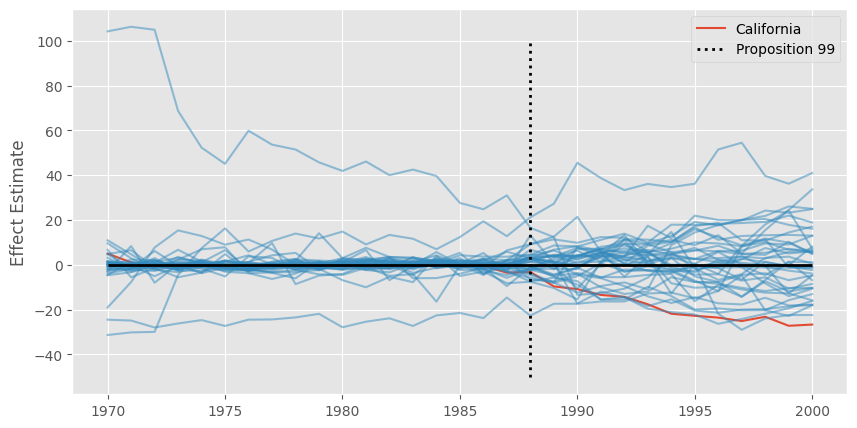

In [8]:
plt.figure(figsize=(10,5))
for state in data.columns:
    
    model_ier = SyntheticControl()
    train_iter = data[data.index < 1988]
    model_ier.fit(train_iter.drop(columns=[state]), train_iter[state])
    
    effect = data[state] - model_ier.predict(data.drop(columns=[state]))
    
    is_california = state == "california"
    
    plt.plot(effect,
             color="C0" if is_california else "C1",
             alpha=1 if is_california else 0.5,
             label="California" if is_california else None)

plt.hlines(y=0, xmin=1970, xmax=2000, lw=2, color="Black")
plt.vlines(x=1988, ymin=-50, ymax=100, linestyle=":", lw=2, label="Proposition 99", color="Black")
plt.ylabel("Effect Estimate")
plt.legend();

In our example, we can see that the post-treatment difference for California is quite extreme, when compared to the other states. However, there are also some states with terrible pre-treatment fit, which then translates to a huge error in the post-intervention period. The guideline here is to remove units with high pretreatment error, but how high is a bit more complicated. Not only that, this procedure assumes a random assignment of the intervention, which is hard to believe for this kind of policy intervention (see Abadie, 2021)
 
One alternative method for inference is to recast the problem of effect estimation as counterfactual prediction. If you think about it, all we are trying to do is predict the counterfactual $Y_{i, t}(0)$ where $i$ is the treated unit and $t \geq T1$, that is, in the post intervention period. If we do that, we can leverage the literature on **Conformal Prediction for inference**. Interestingly enough, this method is quite general and applies to other models of $Y_{i, t}(0)$ but let's focus just on Synthetic Controls here.
 
To understand this procedure, let's first look at how we would do Hypothesis Tests and get P-Values.

### Hypothesis Test and P-Values
 
Let's say we are interested in testing the Hypothesis about the trajectory of effects in the post treatment period $\theta = (\theta_{T0+1}, ..., \theta_{T})$
 
$$
H_0 : \theta = \theta^0
$$
 
For instance, if we wish to test for no effect whatsoever, we can set $\theta^0 = (0, ..., 0)$. Notice that this hypothesis fully determines the counterfactual outcome in the absence of treatment:
 
$$
Y_t(0) = Y_t(1) - \theta_t = Y_t - \theta_t
$$
 
The key idea is to then generate data following the null hypothesis we want to test and check the residuals of a model for $Y(0)$ in this generated data. If the residuals are too extreme, we say that the data is unlikely to have come from the null hypothesis we've postulated. If this whole procedure sounds obscure at first, don't worry, it will become clear as we walk through a step by step implementation of it. 
 
The first step is to generate data under the null hypothesis. This is achieved by simply subtracting the postulated null from the outcome of the treated unit, just like in the equation above. Here is the code to do that.

In [9]:
def with_effect(df, state, null_hypothesis, start_at, window):
    window_mask = (df.index >= start_at) & (df.index < (start_at +window))
    
    y = np.where(window_mask, df[state] - null_hypothesis, df[state])
    
    return df.assign(**{state: y})

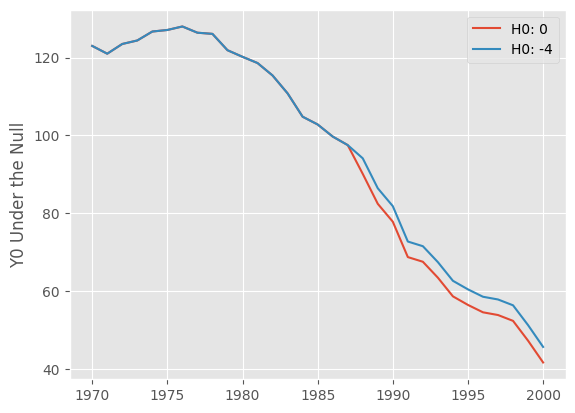

In [10]:
plt.plot(with_effect(data, "california", 0, 1988, 2000-1988+1)["california"], label="H0: 0")
plt.plot(with_effect(data, "california", -4, 1988, 2000-1988+1)["california"], label="H0: -4")

plt.ylabel("Y0 Under the Null")
plt.legend();

If we postulate the null of no effect, the data under that null means that $Y(0) = Y(1) = Y$, which is just the trajectory of observed outcome we see for the treated state of California. Now, if we postulate that the null is -4, that is, Proposition 99 decreases cigarette sales by 4 packs, then $Y(0) = Y(1) - (-4)$, which shifts the trajectory of the post treatment outcomes by +4. This is very intuitive. If we think the bill decreases cigarette sales, then, in the absence of it, we should see higher levels of cigarette sales than the one we have in our observed data. 
 
The next part of the inference procedure is to fit a model for the counterfactual $Y(0)$ (which we get with the function we just created) in the entire data, pre **and** post-treatment period. This is an important distinction between how we usually fit synthetic controls. The idea here is that the model must be estimated with the entire data, under the postulated null hypothesis, to avoid huge post intervention residuals. With this model, we then compute the residuals $\hat{u_t} = Y_t - \hat{Y}_t(0)$ for all time periods $t$.
 
The function to do that first uses the `with_effect` function we created earlier to generate data under then null. Then, it fits the model in this data under the null. Next, we estimate $Y(0)$ by making predictions with the recently fit model. Finally, we compute the residuals $\hat{u}_t$ and stores everything in a dataframe.

In [11]:
@curry
def residuals(df, state, null, intervention_start, window, model):
    
    null_data = with_effect(df, state, null, intervention_start, window)
            
    model.fit(null_data.drop(columns=[state]), null_data[state])
    
    y0_est = pd.Series(model.predict(null_data.drop(columns=[state])), index=null_data.index)
    
    residuals = null_data[state] - y0_est
    
    test_mask = (null_data.index >= intervention_start) & (null_data.index < (intervention_start + window))
    
    return pd.DataFrame({
        "y0": null_data[state],
        "y0_est": y0_est,
        "residuals": residuals,
        "post_intervention": test_mask
    })[lambda d: d.index < (intervention_start + window)]  # just discard  points after the defined effect window

With our data, to get the residuals for $H_0 : 0$, meaning Proposition 99 had no effect, we can simply pass 0 as the null for our function. 

In [12]:
model = SyntheticControl()

residuals_df = residuals(data,
                         "california",
                         null=0.0,
                         intervention_start=1988,
                         window=2000-1988+1,
                         model=model)

residuals_df.head()

,y0,y0_est,residuals,post_intervention
year,,,,
1970,123.000000,112.529475,10.470525,False
1971,121.000000,114.315723,6.684277,False
1972,123.500000,119.302289,4.197711,False
1973,124.400002,121.265554,3.134447,False
1974,126.699997,124.356696,2.343301,False


The result is a dataframe containing the estimated residuals for each time period, something we will use going forward. Remember that the idea here is to see if that residual, in the post intervention period, is too high. If it is, the data is unlikely to have come from this null, where the effect is zero. To get a visual idea of what we are talking about, we can inspect the error of our model in the post intervention period.

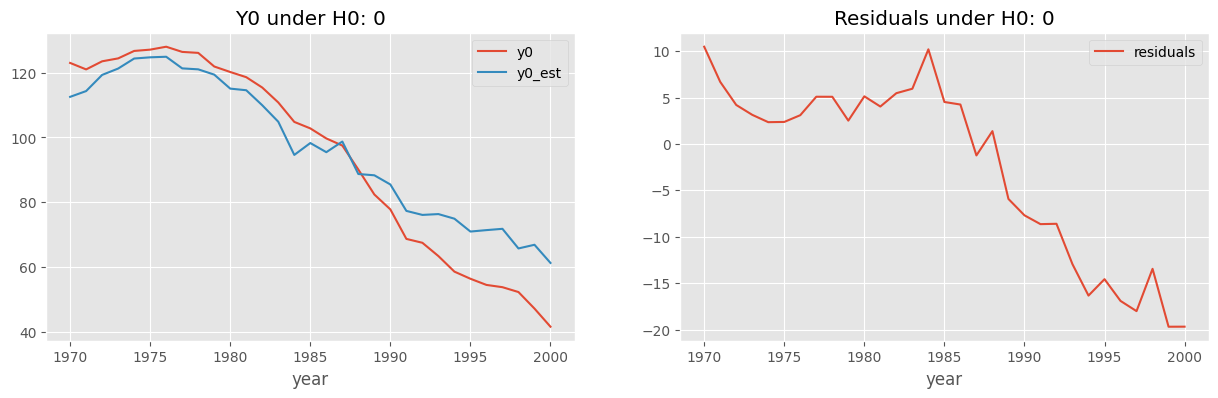

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
residuals_df[["y0", "y0_est"]].plot(ax=ax1)
ax1.set_title("Y0 under H0: 0");
residuals_df[["residuals"]].plot(ax=ax2);
ax2.set_title("Residuals under H0: 0");

We can already see that the model fitted under $H_0: 0$ yields quite large and negative residuals, which is some evidence we might want to reject this null of no effect. 

#### Test Statistic
 
This visual evidence is interesting for our own understanding, but we need to be a bit more precise here. This is done by the definition of a **Test Statistic S**, which summarizes how big are the residuals and hence, how unikly is the data we saw, under the null. 
 
$$
S(\hat{u})_q = \bigg(\sum_{t=T0 + 1}^{T} |u_t|^q \bigg) ^{1/q}
$$
 
Here, we focus on $q=1$, which gives us $S(\hat{u}) = \sum_{t=T0 + 1}^{T} |u_t|$.
 
Notice that this statistic is computed using only the post-intervention period, with $t \geq T0 + 1$. So, although we use all the data to fit our model for the counterfactual $Y(0)$, we check the residuals only for the outcome which concerns the formulated null hypothesis, that is, the post-intervention period. 

In [14]:
def test_statistic(u_hat, q=1, axis=0):
    return (np.abs(u_hat) ** q).mean(axis=axis) ** (1/q)

In [15]:
print("H0:0 ", test_statistic(residuals_df.query("post_intervention")["residuals"]))

H0:0  12.602929955114083


High values of this test statistic indicate poor post intervention fit and, hence rejection of the null. However, we could have pretty big test statistics in the post-intervention period if our model is poorly fitted, even if $H_0$ is true. This means we can't define high in absolute terms. Rather, we have to think about how high are the post intervention residuals - and test statistics - in comparison to the pre-intervention residuals. 
 
#### P-Value
 
To compute the P-value, we block-permute the residuals, calculating the test statistic in each permutation. This procedure is better understood by the following picture
 
![img](data/img/sc-conformal-inf/block-perm.png)
 
Once we do that, we will end up with $T$ test statistics, one for each of the block permutations.
 
Let $\Pi$ be the set of all block permutations, by the definition of P-value 
 
$$
\text{P-value} = \frac{1}{|\Pi|}\sum_{\pi \in \Pi} \mathcal{1}\{S(\hat{u}_{\pi_0}) \leq S(\hat{u}_{\pi})\}
$$
 
and $\hat{u}_{\pi_0}$ is the original (unpermuted) vector or residuals. In plain terms, we are simply finding the proportion of times that the unpermuted test statistic is higher (more extreme) than the test statistics obtained by all possible block permutations. 
 
To implement this, we will make use of the `np.roll` function, which takes an array and circles it, mujustch like we've represented in the image above.

In [16]:
def p_value(resid_df, q=1):
    
    u = resid_df["residuals"].values
    post_intervention = resid_df["post_intervention"].values
    
    block_permutations = np.stack([np.roll(u, permutation, axis=0)[post_intervention]
                                   for permutation in range(len(u))])
    
    statistics = test_statistic(block_permutations, q=1, axis=1)
    
    p_val = np.mean(statistics >= statistics[0])

    return p_val

We can now compute the P-value for $H_0: 0$. As we can see, it is a low P-value, but not extremely low. At $\alpha=0.1$, we would not reject this null of no effect. 

In [17]:
p_value(residuals_df)

0.16129032258064516

Remember, this is the P-value for the null hypothesis which states that the effect in all time periods is zero: $\theta = (\theta_{T0+1}=0, ..., \theta_{T}=0)$. From our effect plot from the Synthetic Control, we get the feeling that the effect of Proposition 99 is not a fixed number. We can see that it starts small, around -5, but gradually increases to -25. For this reason, it might be interesting to plot the confidence interval for effect each post treatment period individually, rather than just testing a null hypothesis about an entire affect trajectory.

### Confidence Intervals
 
To understand how we can place a confidence interval around the effect of each post-treatment period, let's first try to understand how we would define the confidence interval for a single time period. If we have a single period, then $H_0$ is defined in terms of a scalar value, rather than a trajectory vector $\theta$. This means we can generate a fine line of $H_0s$ and compute the P-value associated with each null. For example, Let's say we think the effect of Proposition 99 in the year 1988 (the year it passed) is somewhere between -20 and 20. We can then build a table containing a bunch of $H_0$, from -20 to 20, and each associated P-value:
 
```
P-value(H_0: -20) = 0.01
P-value(H_0: -19) = 0.01
P-value(H_0: -18) = 0.02
...
P-value(H_0: 18) = 0.03
P-value(H_0: 19) = 0.03
P-value(H_0: 20) = 0.02
```
 
With the functions we've defined, this can be achieved by first appending the period of interest (1988 in this example) at the end of the pre-intervention period, creating what is called an augmented dataset. Then, we iterate over the fine line of nulls, computing the p-value of a post-intervention window of size 1, which starts at the period of interest

In [18]:
def p_val_grid(df, state, nulls, intervention_start, period, model):
    
    df_aug = df[df.index < intervention_start].append(df.loc[period])
    
    p_vals =  {null: p_value(residuals(df_aug,
                                       state,
                                       null=null,
                                       intervention_start=period,
                                       window=1,
                                       model=model)) for null in nulls}        
        
    return pd.DataFrame(p_vals, index=[period]).T

In [19]:
model = SyntheticControl()

nulls = np.linspace(-20, 20, 100)

p_values_df = p_val_grid(
    data,
    "california",
    nulls=nulls,
    intervention_start=1988,
    period=1988,
    model=model
)

p_values_df

,1988
-20.000000,0.052632
-19.595960,0.052632
-19.191919,0.052632
-18.787879,0.052632
-18.383838,0.052632
...,...
18.383838,0.052632
18.787879,0.052632
19.191919,0.052632
19.595960,0.052632


As you can see, the result is a table where the row index is the null hypothesis and the row values are the p-values.
 
To build the confidence interval, all we need to do is filter out the $H_0$s that gave us a low P-value. Remember that low p-value means that the data we have is unlikely to have come from that null. For instance, if we define the significant level $\alpha$ to be 0.1, we remove $H_0$s that have P-value lower than 0.1. 

In [20]:
def confidence_interval_from_p_values(p_values, alpha=0.1):
    big_p_values = p_values[p_values.values >= alpha]
    return pd.DataFrame({
        f"{int(100-alpha*100)}_ci_lower": big_p_values.index.min(),
        f"{int(100-alpha*100)}_ci_upper": big_p_values.index.max(),
    }, index=[p_values.columns[0]])

In [21]:
confidence_interval_from_p_values(p_values_df)

,90_ci_lower,90_ci_upper
1988,-12.323232,8.686869


This gives us the confidence interval for the effect in 1988.
 
We can also plot the $H_0$ by P-value to better understand how this confidence interval was obtained. In the figure below, the dashed line is the 0.1 line, which is the $\alpha$ we've specified. The blue lines mark the confidence intervals. $H_0$ outside these lines have a P-value lower than 0.1.

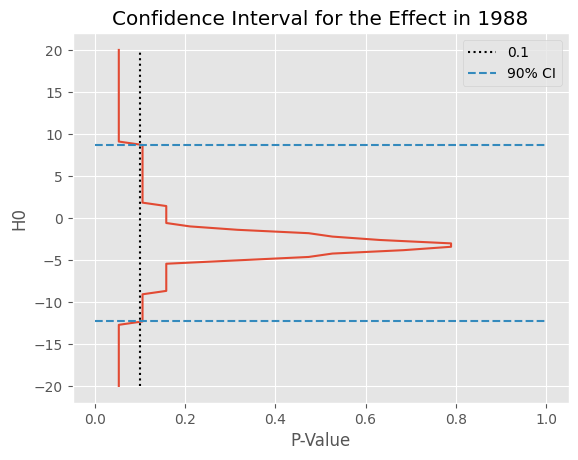

In [22]:
plt.plot(p_values_df[1988], p_values_df.index)
plt.xlabel("P-Value")
plt.ylabel("H0")
plt.vlines(0.1, nulls.min(), nulls.max(), color="black", ls="dotted", label="0.1")

plt.hlines(confidence_interval_from_p_values(p_values_df)["90_ci_upper"], 0, 1, color="C1", ls="dashed")
plt.hlines(confidence_interval_from_p_values(p_values_df)["90_ci_lower"], 0, 1, color="C1", ls="dashed", label="90% CI")

plt.legend()
plt.title("Confidence Interval for the Effect in 1988");

All there's left to do is repeat the procedure above for each time period. This means that, for each post intervention year, appending it to the end of the pre-intervention period to create the augmented dataset and then computing the confidence interval just like we've done above.
 
![img](data/img/sc-conformal-inf/aug-data.png)

In [23]:
def compute_period_ci(df, state, nulls, intervention_start, period, model, alpha=0.1):
    p_vals = p_val_grid(df=df,
                        state=state,
                        nulls=nulls,
                        intervention_start=intervention_start,
                        period=period,
                        model=model)
    
    return confidence_interval_from_p_values(p_vals, alpha=alpha)


def confidence_interval(df, state, nulls, intervention_start, window, model, alpha=0.1, jobs=4):    
    return pd.concat([compute_period_ci(df, state, nulls, intervention_start, period, model, alpha)
                     for period in range(intervention_start, intervention_start+window)])

We are now ready to compute the confidence interval for all the post-intervention periods

In [24]:
model = SyntheticControl()

nulls = np.linspace(-60, 20, 100)

ci_df = confidence_interval(
    data,
    "california",
    nulls=nulls,
    intervention_start=1988,
    window=2000 - 1988 + 1,
    model=model
)

ci_df

,90_ci_lower,90_ci_upper
1988,-12.323232,8.686869
1989,-16.363636,2.222222
1990,-17.171717,5.454545
1991,-19.595960,-5.858586
1992,-22.828283,-7.474747
1993,-32.525253,-12.323232
1994,-36.565657,-15.555556
1995,-43.030303,-14.747475
1996,-41.414141,-16.363636
1997,-48.686869,-13.131313


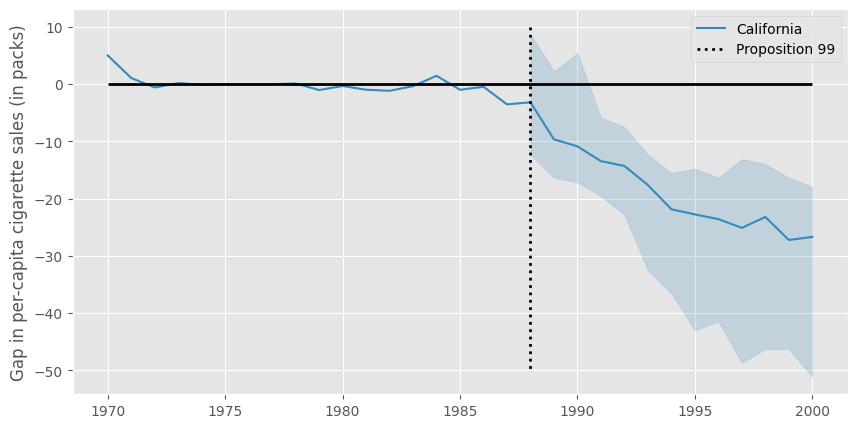

In [25]:
plt.figure(figsize=(10,5))
plt.fill_between(ci_df.index, ci_df["90_ci_lower"], ci_df["90_ci_upper"], alpha=0.2,  color="C1")
plt.plot(pred_data["california"].index, pred_data["residuals"], label="California", color="C1")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2, color="Black")
plt.vlines(x=1988, ymin=10, ymax=-50, linestyle=":", color="Black", lw=2, label="Proposition 99")
plt.legend()
plt.ylabel("Gap in per-capita cigarette sales (in packs)");

## Reference
 
This Appendix based on the paper *An Exact and Robust Conformal Inference Method for Counterfactual and Synthetic Controls*, by Victor Chernozhukov, Kaspar Wüthrich, Yinchu Zhu. I would like to give special thanks to Kaspar, who clarified a lot of the questions I had. 
 
For additional resources on Synthetic Controls, check out *Using Synthetic Controls: Feasibility, Data Requirements, and Methodological Aspects*, by Alberto Abadie (2021). 
 
## Contribute
 
Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).